In [1]:
from dask.distributed import Client
from dask import delayed

In [16]:
import dask.bag as db
import os
import json
from operator import itemgetter
from operator import add

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import word_tokenize

from collections import Counter

import time


In [3]:
#make client

client = Client()
client

Client Scheduler: tcp://127.0.0.1:46257 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 12 Memory: 16.80 GB


In [4]:
#load data and repartition
filename = os.path.join('data', 'papers_in_json_singleline', '*.json')
lines = db.read_text(filename)
js = lines.map(json.loads).repartition(10)

## definition of functions

In [5]:
#merge all the body texts in one for each file
def merge(record):
    text=''
    for rec in record:
        text+=rec['text']
    return text

texts = js.pluck("body_text").map(merge)
texts.take(1)

('Plasmodium falciparum, which causes malignant malaria such as cerebral malaria (CM) or pregnancy-associated malaria (PAM) [1, 2] , is the cause of death to 435,000 individuals annually [3] . Plasmodium falciparum erythrocyte membrane protein 1 (PfEMP1), which is encoded by the var gene family comprising approximately 60 members, is the major virulence factor involved in the antigenic variation and clinical pathogenicity of falciparum malaria [4, 5] . It is remarkable that the expression of var family members is mutually exclusive. For each parasite at a time, only one or a few var genes are expressed, while the remaining members are silenced [6, 7] . In each generation, P. falciparum is able to express different var genes, and the switches in var gene expression lead to antigenic variation of PfEMP1, which results in immune evasion and chronic infection [8] [9] [10] [11] . This process has proven to be mediated by epigenetic mechanisms, including chromatin modification, nuclear archi

In [6]:
#function for text cleaning
#we remove punctuation, numbers and stopwords 
#stopwords are taken from a library but also definied by us
#after this files are lists of words

tokenizer = RegexpTokenizer(r'\w+')
no_words={"i", "as", "or", "it", "et", "also", "may"}

def clean_func(text):

    def merge_text(text,stop_words):
        new_sentence =''
        for w in text:
            if w.lower() not in stop_words and w.isalpha(): 
                new_sentence += w 
                new_sentence += " "
        return new_sentence

    stop_words = set(stopwords.words('english'))
    result = word_tokenize(text)
    result = merge_text(result,stop_words.union(no_words))
    result = tokenizer.tokenize(result)
    return result

text_clean = texts.map(clean_func)
text_clean.take(1)

(['Plasmodium',
  'falciparum',
  'causes',
  'malignant',
  'malaria',
  'cerebral',
  'malaria',
  'CM',
  'malaria',
  'PAM',
  'cause',
  'death',
  'individuals',
  'annually',
  'Plasmodium',
  'falciparum',
  'erythrocyte',
  'membrane',
  'protein',
  'encoded',
  'var',
  'gene',
  'family',
  'comprising',
  'approximately',
  'members',
  'major',
  'virulence',
  'factor',
  'involved',
  'antigenic',
  'variation',
  'clinical',
  'pathogenicity',
  'falciparum',
  'malaria',
  'remarkable',
  'expression',
  'var',
  'family',
  'members',
  'mutually',
  'exclusive',
  'parasite',
  'time',
  'one',
  'var',
  'genes',
  'expressed',
  'remaining',
  'members',
  'silenced',
  'generation',
  'falciparum',
  'able',
  'express',
  'different',
  'var',
  'genes',
  'switches',
  'var',
  'gene',
  'expression',
  'lead',
  'antigenic',
  'variation',
  'results',
  'immune',
  'evasion',
  'chronic',
  'infection',
  'process',
  'proven',
  'mediated',
  'epigenetic',
 

In [7]:
# we transform each list in a list of dictionaries 
#where the unique words and their frequency is stored

def count_words(text):
    counts = dict(zip(Counter(text).keys(), Counter(text).values()))
    wList = [{"word":x , "counts": y} for x,y in counts.items()]
    return wList

words = text_clean.map(count_words)
words.take(1)

([{'word': 'Plasmodium', 'counts': 5},
  {'word': 'falciparum', 'counts': 27},
  {'word': 'causes', 'counts': 2},
  {'word': 'malignant', 'counts': 1},
  {'word': 'malaria', 'counts': 6},
  {'word': 'cerebral', 'counts': 1},
  {'word': 'CM', 'counts': 1},
  {'word': 'PAM', 'counts': 1},
  {'word': 'cause', 'counts': 1},
  {'word': 'death', 'counts': 1},
  {'word': 'individuals', 'counts': 1},
  {'word': 'annually', 'counts': 1},
  {'word': 'erythrocyte', 'counts': 1},
  {'word': 'membrane', 'counts': 1},
  {'word': 'protein', 'counts': 19},
  {'word': 'encoded', 'counts': 1},
  {'word': 'var', 'counts': 58},
  {'word': 'gene', 'counts': 36},
  {'word': 'family', 'counts': 6},
  {'word': 'comprising', 'counts': 2},
  {'word': 'approximately', 'counts': 2},
  {'word': 'members', 'counts': 4},
  {'word': 'major', 'counts': 5},
  {'word': 'virulence', 'counts': 3},
  {'word': 'factor', 'counts': 2},
  {'word': 'involved', 'counts': 9},
  {'word': 'antigenic', 'counts': 3},
  {'word': 'vari

In [9]:
# at last we sum over all file using the foldby method
# we pass the bag to the foldby after flattening it 
#the methos accesse the dictiornarios gropyng them with the value associated to the key word
# and the sum the counts of each word

def incr_amount(tot, x):
    return tot+x['counts']


total_counts = words.flatten().foldby('word', binop=incr_amount, 
                   initial=0, 
                   combine=add, 
                   combine_initial=0).compute()

total_counts

[('Plasmodium', 57),
 ('falciparum', 95),
 ('causes', 728),
 ('malignant', 171),
 ('malaria', 205),
 ('cerebral', 398),
 ('CM', 12),
 ('PAM', 14),
 ('cause', 1356),
 ('death', 1077),
 ('individuals', 1341),
 ('annually', 67),
 ('erythrocyte', 34),
 ('membrane', 1146),
 ('protein', 5049),
 ('encoded', 278),
 ('var', 124),
 ('gene', 2904),
 ('family', 1048),
 ('comprising', 113),
 ('approximately', 705),
 ('members', 658),
 ('major', 1578),
 ('virulence', 259),
 ('factor', 1316),
 ('involved', 1401),
 ('antigenic', 291),
 ('variation', 433),
 ('clinical', 4288),
 ('pathogenicity', 101),
 ('remarkable', 110),
 ('expression', 3567),
 ('mutually', 41),
 ('exclusive', 64),
 ('parasite', 291),
 ('time', 4485),
 ('one', 4710),
 ('genes', 2202),
 ('expressed', 1212),
 ('remaining', 376),
 ('silenced', 12),
 ('generation', 413),
 ('able', 1008),
 ('express', 346),
 ('different', 4573),
 ('switches', 27),
 ('lead', 853),
 ('results', 4390),
 ('immune', 2303),
 ('evasion', 50),
 ('chronic', 1073),

In [10]:
# at last we order the obtained list

total_counts_ordered = sorted(total_counts, key=itemgetter(1), reverse=True)
total_counts_ordered

[('patients', 11586),
 ('cells', 10922),
 ('virus', 8326),
 ('study', 7376),
 ('infection', 7301),
 ('used', 7056),
 ('using', 6987),
 ('viral', 5890),
 ('data', 5870),
 ('disease', 5763),
 ('al', 5622),
 ('cell', 5244),
 ('two', 5076),
 ('protein', 5049),
 ('Fig', 4747),
 ('one', 4710),
 ('different', 4573),
 ('time', 4485),
 ('studies', 4426),
 ('results', 4390),
 ('clinical', 4288),
 ('could', 4074),
 ('number', 4047),
 ('human', 4018),
 ('cases', 4015),
 ('analysis', 3762),
 ('However', 3759),
 ('use', 3741),
 ('treatment', 3726),
 ('found', 3687),
 ('group', 3684),
 ('high', 3664),
 ('RNA', 3642),
 ('viruses', 3638),
 ('expression', 3567),
 ('respiratory', 3498),
 ('Figure', 3495),
 ('model', 3488),
 ('including', 3431),
 ('shown', 3392),
 ('associated', 3359),
 ('reported', 3332),
 ('control', 3323),
 ('first', 3279),
 ('system', 3190),
 ('response', 3168),
 ('well', 3123),
 ('proteins', 3061),
 ('infections', 2983),
 ('compared', 2961),
 ('Table', 2939),
 ('performed', 2908),
 (

In [17]:
#timing of the operation

start = time.time()
word_count = (lines.map(json.loads).repartition(10).pluck('body_text')
                   .map(merge).map(clean_func)
                   .map(count_words).flatten()
                   .foldby('word', binop=incr_amount, 
                        initial=0, combine=add, 
                        combine_initial=0).compute())
word_sorted = sorted(word_count, key=itemgetter(1), reverse=True)
end = time.time()

print("time: ", end - start)
print(word_sorted[:10])

time:  15.033525705337524
[('patients', 11586), ('cells', 10922), ('virus', 8326), ('study', 7376), ('infection', 7301), ('used', 7056), ('using', 6987), ('viral', 5890), ('data', 5870), ('disease', 5763)]


In [22]:
client.close()

In [19]:
from dask.distributed import Client, LocalCluster

In [26]:
cluster.scale(3)
cluster.close()

In [20]:
cluster = LocalCluster(n_workers=2)
client = Client(cluster)

In [21]:
start = time.time()
word_count = (lines.map(json.loads).repartition(10).pluck('body_text')
                   .map(merge).map(clean_func)
                   .map(count_words).flatten()
                   .foldby('word', binop=incr_amount, 
                        initial=0, combine=add, 
                        combine_initial=0).compute())
word_sorted = sorted(word_count, key=itemgetter(1), reverse=True)
end = time.time()

print("time: ", end - start)
print(word_sorted[:10])

time:  26.289905309677124
[('patients', 11586), ('cells', 10922), ('virus', 8326), ('study', 7376), ('infection', 7301), ('used', 7056), ('using', 6987), ('viral', 5890), ('data', 5870), ('disease', 5763)]


In [36]:
def get_time(workers=4, partitions=10):
    myCluster = LocalCluster(n_workers=workers)
    client = Client(myCluster) #make client
    start = time.time() #strat taking time
    word_count = (lines.map(json.loads).repartition(partitions).pluck('body_text')
                       .map(merge).map(clean_func)
                       .map(count_words).flatten()
                       .foldby('word', binop=incr_amount, 
                            initial=0, combine=add, 
                            combine_initial=0).compute())
    word_sorted = sorted(word_count, key=itemgetter(1), reverse=True)
    end = time.time()
    client.close() #close client
    myCluster.close() #close cluster
    return end-start
    

In [34]:
for nw in range (3,5):
    print("nw ", nw, " time ", get_time(nw))

nw  3  time  20.467097282409668
nw  4  time  16.26418685913086


In [37]:
#works = [1,2,3,4,5,6,7,8]
#parts = [1,2,5,10,50, 100, 150]
works = [8]
parts = [8]
for w in works:
    for p in parts:
        print("nw: ", w, " Partitions ", p, " time: ", get_time(w,p))

nw:  1  Partitions  1  time:  41.821526765823364
nw:  1  Partitions  2  time:  46.093825817108154
nw:  1  Partitions  5  time:  49.007508516311646
nw:  1  Partitions  10  time:  50.08442950248718
nw:  1  Partitions  50  time:  51.23566436767578
nw:  1  Partitions  100  time:  53.18799328804016
nw:  1  Partitions  150  time:  53.97339224815369
nw:  2  Partitions  1  time:  37.030092000961304
nw:  2  Partitions  2  time:  25.45044445991516
nw:  2  Partitions  5  time:  29.384906768798828
nw:  2  Partitions  10  time:  26.63882541656494
nw:  2  Partitions  50  time:  27.028435945510864
nw:  2  Partitions  100  time:  27.976499557495117
nw:  2  Partitions  150  time:  28.662083387374878
nw:  3  Partitions  1  time:  35.09145712852478
nw:  3  Partitions  2  time:  22.952028274536133
nw:  3  Partitions  5  time:  31.062424898147583
nw:  3  Partitions  10  time:  21.793434858322144
nw:  3  Partitions  50  time:  19.234987020492554
nw:  3  Partitions  100  time:  19.518953800201416
nw:  3  Par

In [50]:
get_time(12, 12)

10.046005487442017

In [42]:
get_time(24, 48)

11.118107795715332

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import bokeh.palettes as palette

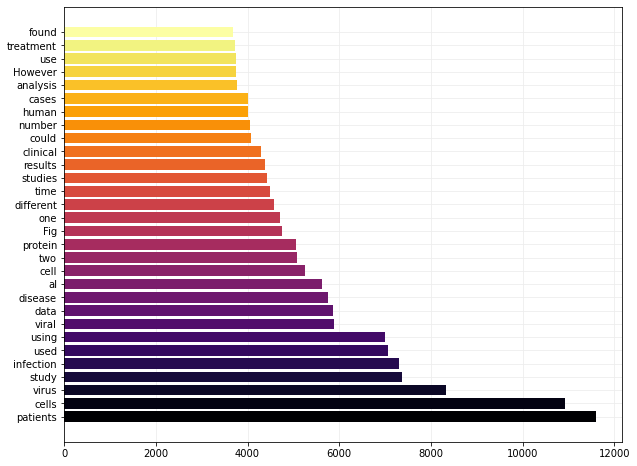

In [54]:
height = [word_sorted[i][1] for i in range(0,len(word_sorted))]
bars = [word_sorted[i][0] for i in range(0,len(word_sorted))]
y_pos = np.arange(len(bars))

fig, ax = plt.subplots(figsize=(10,8))
index = 30
# Create bars
ax.barh(y_pos[:index], height[:index],color=palette.inferno(index))
plt.yticks(y_pos[:index], bars[:index])
ax.grid(True, which="both", ls="-",color='0.93')
ax.set_axisbelow(True)

## parte 2

In [55]:
filename = os.path.join('data', 'papers_in_json_singleline', '*.json')
lines = db.read_text(filename)
js = lines.map(json.loads).repartition(10)

In [59]:
cluster=LocalCluster(n_workers=4)
client= Client(cluster)

In [64]:
js.pluck('metadata').pluck('authors').take(2)

([{'first': 'Wei-Feng',
   'middle': [],
   'last': 'Wang',
   'suffix': '',
   'affiliation': {'laboratory': '',
    'institution': 'Second Military Medical University',
    'location': {'postCode': '200433',
     'settlement': 'Shanghai',
     'country': 'China'}},
   'email': ''},
  {'first': 'Yi-Long',
   'middle': [],
   'last': 'Zhang',
   'suffix': '',
   'affiliation': {'laboratory': '',
    'institution': 'Second Military Medical University',
    'location': {'postCode': '200433',
     'settlement': 'Shanghai',
     'country': 'China'}},
   'email': ''}],
 [{'first': 'Wei-Feng',
   'middle': [],
   'last': 'Wang',
   'suffix': '',
   'affiliation': {'laboratory': '',
    'institution': 'Second Military Medical University',
    'location': {'postCode': '200433',
     'settlement': 'Shanghai',
     'country': 'China'}},
   'email': ''},
  {'first': 'Yi-Long',
   'middle': [],
   'last': 'Zhang',
   'suffix': '',
   'affiliation': {'laboratory': '',
    'institution': 'Second Mil

In [65]:
authors = js.pluck('metadata').pluck('authors')

In [88]:
def flatten(record):
    uni=loc=lab=''
    if 'institution' in record['affiliation'].keys():
        uni=record['affiliation']['institution']
    else: uni="Unknown"
    
    if 'laboratory' in record['affiliation'].keys():
        lab=record['affiliation']['laboratory']
    else: lab="Unknown"
    
    if 'location' in record['affiliation'].keys():
        if 'country' in record['affiliation']['location'].keys():
            loc=record['affiliation']['location']['country']
        else: loc="Unknown"
    else: loc="Unknown"
    
    if uni=='': uni="Unknown"
    if lab=='': lab="Unknown"
    if loc=='': loc="Unknown"
    
    return {
        'name':       record['first'],
        'surname':    record['last'], 
        'University': uni,
        'Laboratory': lab,
        'Country':    loc,
    }

authors.flatten().map(flatten).take(12)

({'name': 'Wei-Feng',
  'surname': 'Wang',
  'University': 'Second Military Medical University',
  'Laboratory': 'Unknown',
  'Country': 'China'},
 {'name': 'Yi-Long',
  'surname': 'Zhang',
  'University': 'Second Military Medical University',
  'Laboratory': 'Unknown',
  'Country': 'China'},
 {'name': 'Wei-Feng',
  'surname': 'Wang',
  'University': 'Second Military Medical University',
  'Laboratory': 'Unknown',
  'Country': 'China'},
 {'name': 'Yi-Long',
  'surname': 'Zhang',
  'University': 'Second Military Medical University',
  'Laboratory': 'Unknown',
  'Country': 'China'},
 {'name': 'Chih-Cheng',
  'surname': 'Lai',
  'University': 'Chi Mei Medical Center',
  'Laboratory': 'Unknown',
  'Country': 'Taiwan'},
 {'name': 'Chen-Chen',
  'surname': 'Chu',
  'University': 'National Taiwan University Hospital',
  'Laboratory': 'Unknown',
  'Country': 'Taiwan'},
 {'name': 'Aristine',
  'surname': 'Cheng',
  'University': 'New Taipei City',
  'Laboratory': 'Unknown',
  'Country': 'Taiwan

In [90]:
auth_df = authors.flatten().map(flatten).to_dataframe()
df.head()

,name,surname,University,Laboratory,Country
0,Wei-Feng,Wang,Second Military Medical University,Unknown,China
1,Yi-Long,Zhang,Second Military Medical University,Unknown,China
2,Wei-Feng,Wang,Second Military Medical University,Unknown,China
3,Yi-Long,Zhang,Second Military Medical University,Unknown,China
4,Chih-Cheng,Lai,Chi Mei Medical Center,Unknown,Taiwan


In [99]:
univs = auth_df.University.value_counts().nlargest(10).compute()
univs

Unknown                              2705
The University of Hong Kong            57
Verona University Hospital Trust       55
Chinese Academy of Sciences            42
University of California               29
Third Military Medical University      27
Huazhong Agricultural University       26
Fudan University                       26
Utrecht University                     25
Zhejiang University                    23
Name: University, dtype: int64

In [97]:
labos = auth_df.Laboratory.value_counts().nlargest(10).compute()
labos

Unknown                                                                                                                                                                                                                   5453
M.P. Koopmans); Public Health Service Haaglanden, The Hague, the Netherlands (K. Dirksen); Medical Centre Haaglanden, The Hague (C. Jansen, L.B.S. Gelinck, E.M.S. Leyten); Public Health Service Ijsselland                26
Li Ka Shing                                                                                                                                                                                                                 21
State Key Laboratory of Agricultural Microbiology                                                                                                                                                                           20
State Key Laboratory of Veterinary Biotechnology                                                            

In [98]:
countries = auth_df.Country.value_counts().nlargest(10).compute()
countries

Unknown    3117
China       619
USA         370
Italy       222
France      113
UK          110
Spain       109
Canada      103
Japan        94
Brazil       72
Name: Country, dtype: int64

In [105]:
def get_time_univs(workers=4, partitions=10):
    myCluster = LocalCluster(n_workers=workers)
    client = Client(myCluster) #make client
    start = time.time() #strat taking time
    auth_df = (lines.map(json.loads).repartition(10)
                    .pluck('metadata').pluck('authors')
                    .flatten().map(flatten)
                    .to_dataframe())
    univs = auth_df.University.value_counts().nlargest(10).compute()
    end = time.time()
    client.close() #close client
    myCluster.close() #close cluster
    return end-start

def get_time_countries(workers=4, partitions=10):
    myCluster = LocalCluster(n_workers=workers)
    client = Client(myCluster) #make client
    start = time.time() #strat taking time
    auth_df = (lines.map(json.loads).repartition(10)
                    .pluck('metadata').pluck('authors')
                    .flatten().map(flatten)
                    .to_dataframe())
    countries = auth_df.Country.value_counts().nlargest(10).compute()
    end = time.time()
    client.close() #close client
    myCluster.close() #close cluster
    return end-start

def get_N_univs(workers=4, partitions=10, N=10):
    myCluster = LocalCluster(n_workers=workers)
    client = Client(myCluster) #make client
    auth_df = (lines.map(json.loads).repartition(10)
                    .pluck('metadata').pluck('authors')
                    .flatten().map(flatten)
                    .to_dataframe())
    univs = auth_df.University.value_counts().nlargest(N).compute()
    client.close() #close client
    myCluster.close() #close cluster
    return univs
def get_N_countries(workers=4, partitions=10, N=10):
    myCluster = LocalCluster(n_workers=workers)
    client = Client(myCluster) #make client
    auth_df = (lines.map(json.loads).repartition(10)
                    .pluck('metadata').pluck('authors')
                    .flatten().map(flatten)
                    .to_dataframe())
    countries = auth_df.Country.value_counts().nlargest(N).compute()
    client.close() #close client
    myCluster.close() #close cluster
    return countries
    

In [106]:
get_time_univs(10,10)

/home/alessandro/.local/lib/python3.6/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


6.3726301193237305

In [107]:
get_time_countries(10,10)

/home/alessandro/.local/lib/python3.6/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


5.047595739364624

In [108]:
get_N_univs(10,10, 10)

/home/alessandro/.local/lib/python3.6/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Unknown                              2705
The University of Hong Kong            57
Verona University Hospital Trust       55
Chinese Academy of Sciences            42
University of California               29
Third Military Medical University      27
Huazhong Agricultural University       26
Fudan University                       26
Utrecht University                     25
Zhejiang University                    23
Name: University, dtype: int64

In [109]:
get_N_countries(10,10, 10)

/home/alessandro/.local/lib/python3.6/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Unknown    3117
China       619
USA         370
Italy       222
France      113
UK          110
Spain       109
Canada      103
Japan        94
Brazil       72
Name: Country, dtype: int64